In [15]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import Image
from lxml import objectify
import math
import time
from pytrends.request import TrendReq
from wordcloud import WordCloud
from ast import literal_eval
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import numpy as np

#Import data from wikidata.org
from wikidata2df import wikidata2df

#Convert country name to ISO-3
import country_converter as coco

#World map plot librairies
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.express as px
import plotly.graph_objs as go

# Analysis of the lexical fields
from empath import Empath 

#Warnings
import warnings

data_folder = './data/'

In [16]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,0.0,0.0,7.0,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge
7,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,0.0,8.0,5.0,1678.0,12.0,7.0,Mary,Banks,F,Julie Andrews
13,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,0.0,4.0,9.0,730.0,11.0,4.0,Jody,Yvette,M,Tyrese Gibson
20,25960460,/m/0b6kc_5,Daddy and Them,2001,NaN,101.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'Netherlands']","['Black comedy', 'Comedy']",86%,...,0.0,1.0,0.0,71.0,0.0,0.0,Claude,Montgomery,M,Billy Bob Thornton
25,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,0.0,0.0,3.0,334.0,2.0,2.0,Crowe,NaN,F,Peggy Lipton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34388,26219108,/m/0b76gfr,The Leopard Woman,NaN,NaN,70.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Silent film', 'Romance Film']",NaN,...,0.0,5.0,2.0,306.0,1.0,3.0,Culbertson,Chak,NaN,Shirley MacLaine
34389,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,0.0,6.0,4.0,548.0,10.0,0.0,Akeem,Lisa,M,Eddie Murphy
34393,22330502,/m/05sync6,Inspiration,1931-01-31,NaN,74.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,0.0,2.0,0.0,164.0,2.0,0.0,Yvonne,Valbret,F,Greta Garbo
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,0.0,2.0,1.0,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles


In [17]:
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()

In [18]:
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])

In [19]:
#df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa = df_movie_usa.dropna(subset=['RT average_x'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].str.replace("\%", "", regex=True)
df_movie_usa['RT average_x'] = df_movie_usa['RT average_x'].str.split('/').str[0].astype(float)
df_movie_usa['TS score_x'] = df_movie_usa['TS score_x'].astype(float)
df_movie_usa.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [20]:
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['Movie_date']>decade[0:3]) & (df_movie_usa['Movie_date']<decade[5:8])].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [21]:
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [22]:
df_movie_group = df_movie_usa.groupby(['Decade'],group_keys = True).apply(lambda x:x)
df_movie_group.index = df_movie_group.index.droplevel(1)
df_movie_group.rename_axis(None, axis=1).rename_axis('id', axis=0)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender
id,,,,,,,,,,,,,,,,,,,,,
0,27463222,/m/0c037x9,Vanishing on 7th Street,2010-09-12,NaN,92.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Horror', 'Supernatural', 'Gothic...",48.0,...,12.0,1.0,Luke,Paul,Hayden Christensen,Hayden Christensen,M,2010,0,1
0,33144131,/m/0gfrkw7,Fly Away,2010,NaN,80.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic drama', 'Romance Film', 'Drama']",85.0,...,6.0,16.0,Jeanne,Mandy,Brad Davis,Brad Davis,M,2010,0,1
0,24021571,/m/07kbj2s,Just Wright,2010-05-14,21570263.0,101.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Sports', 'Drama', 'Comedy...",46.0,...,6.0,6.0,Leslie,Scott,Queen Latifah,Queen Latifah,F,2010,0,0
0,28530363,/m/0crs5bt,The Way,2010-09-10,4430765.0,123.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","['United States of America', 'Spain']","['Drama', 'Adventure', 'Comedy']",83.0,...,2.0,1.0,Tom,Thomas,Martin Sheen,Martin Sheen,M,2010,0,1
0,22358819,/m/05szq8z,Clash of the Titans,2010-03-26,493214993.0,96.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'United Kingdom']","['Adventure', 'Remake', 'Action/Adventure', 'F...",27.0,...,10.0,4.0,Perseus,Andromeda,Sam Worthington,Sam Worthington,M,2010,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2610454,/m/07rjx2,Zombies,2006-11-17,NaN,94.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Zombie Film', 'Horror', 'Supernatural']",40.0,...,5.0,1.0,Karen,Emma,Reginald Denny,Reginald Denny,M,2006,7,1
7,3592692,/m/09nl36,Inside Man,2006-03-16,NaN,128.0,"{""/m/012v8"": ""Albanian language"", ""/m/02h40lc""...",['United States of America'],"['Thriller', 'Crime Fiction', 'Master Criminal...",86.0,...,16.0,3.0,Russell,Frazier,Clive Owen,Clive Owen,M,2006,7,1
7,883432,/m/03ljpk,Gone in Sixty Seconds,2000,237202298.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Thriller', 'Heist', 'Action...",25.0,...,0.0,0.0,Raines,Kip,Nicolas Cage,Nicolas Cage,M,2000,7,1


In [23]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of athletes discarded is : 2652
The number of matched pairs is : 1781


In [24]:
import statsmodels.formula.api as smf

In [25]:
mod = smf.ols(formula='TSscore ~ C(gender)', data=df_matched.loc[7])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.308
Date:                Sat, 17 Dec 2022   Prob (F-statistic):            0.00696
Time:                        14:19:28   Log-Likelihood:                -5733.5
No. Observations:                1226   AIC:                         1.147e+04
Df Residuals:                    1224   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         45.3556      1.051     43.

In [26]:
# Linear regression with y the logarithm of pageviews and x1 the boolean value of is_after
mod = smf.ols(formula='RTaverage ~ gender + Decade', data=df_matched)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     113.5
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.72e-48
Time:                        14:19:28   Log-Likelihood:                -6284.2
No. Observations:                3562   AIC:                         1.257e+04
Df Residuals:                    3559   BIC:                         1.259e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4578      0.057    113.646      0.0

In [27]:
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

eval_env: 1
eval_env: 1
eval_env: 1


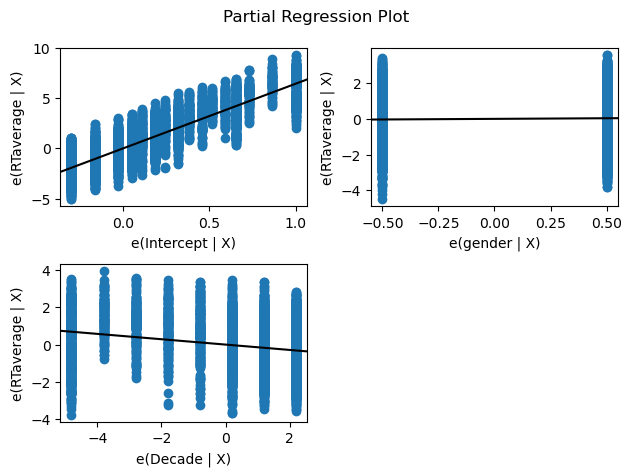

In [28]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [29]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import numpy as np

In [30]:
# Linear regression with y the logarithm of pageviews and x1 the boolean value of is_after
for i in list(df_matched.Decade.index.value_counts().index):
    mod = smf.ols(formula='TSscore ~ C(gender)', data=df_matched.loc[i])
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.308
Date:                Sat, 17 Dec 2022   Prob (F-statistic):            0.00696
Time:                        14:19:29   Log-Likelihood:                -5733.5
No. Observations:                1226   AIC:                         1.147e+04
Df Residuals:                    1224   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         45.3556      1.051     43.

In [31]:
mod = smf.ols(formula='TSscore ~ C(gender)', data=df_matched.loc[1:6])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5566
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.456
Time:                        14:19:29   Log-Likelihood:                -11169.
No. Observations:                2336   AIC:                         2.234e+04
Df Residuals:                    2334   BIC:                         2.235e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         59.9443      0.845     70.

In [32]:
mod = smf.ols(formula='RTaverage ~ C(gender)', data=df_matched.loc[1:6])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.002217
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.962
Time:                        14:19:29   Log-Likelihood:                -4251.7
No. Observations:                2336   AIC:                             8507.
Df Residuals:                    2334   BIC:                             8519.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0090      0.044    137.

In [33]:
mod = smf.ols(formula='RTaverage ~ C(gender)', data=df_matched.loc[1:6])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.002217
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.962
Time:                        14:19:29   Log-Likelihood:                -4251.7
No. Observations:                2336   AIC:                             8507.
Df Residuals:                    2334   BIC:                             8519.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0090      0.044    137.

# Revenue

In [34]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = df_movie_usa.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
df_movie_usa = merge.drop(columns=['Principal_character_sex'])
df_movie_usa = df_movie_usa[(df_movie_usa.Actor_gender == 'M') | (df_movie_usa.Actor_gender == 'F')]
df_character_usa = pd.read_csv('df_character_usa.csv')
df_movie_usa = df_movie_usa.dropna(subset=['Movie_date'])
df_movie_usa['year'] = df_movie_usa['Movie_date'].apply(lambda x: int(x[0:4]))
df_movie_usa['Movie_revenue'] = df_movie_usa['Movie_revenue'].astype(float)
df_movie_usa = df_movie_usa.dropna(subset=['Movie_revenue'])
df_movie_usa['gender'] = df_movie_usa['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [35]:
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))
df_movie_usa['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = df_movie_usa[ (df_movie_usa['Movie_date']>decade[0:3]) & (df_movie_usa['Movie_date']<decade[5:8])].index
    df_movie_usa.loc[index1,'Decade'] = decades_code[ctr]

In [36]:
#create a SPARQL wikidata query to retrieve the rotten tomatoes score review when available
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''
US_film_rev = wikidata2df(US_rev)  #convert the json file from the query into a pandas dataframe

In [37]:
box = '''
SELECT ?revenueLabel ?freebase_ID ?in
WHERE {
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    ?movie wdt:P31 wd:Q11424;
    wdt:P495 wd:Q30;
    wdt:P646 ?freebase_ID;
    p:P2142 ?revenuee.
    ?revenuee ps:P2142 ?revenue.
}
'''

In [38]:
boxdf = wikidata2df(box)
boxdf

,revenueLabel,freebase_ID
0,89328627,/m/0rfdcdn
1,312242626,/m/0w01nbr
2,203300000,/m/0vpv29q
3,18700000,/m/0tkj5w3
4,24177137,/m/0w2zz_z
...,...,...
2102,57479076,/m/08hxvl
2103,227853986,/m/033g1f
2104,251200000,/m/0d1s52
2105,8100000,/m/09g2y_


In [39]:
df_movie_usamerged = df_movie_usa.merge(boxdf, left_on='Freebase_movie_ID', right_on='freebase_ID', how='left')
df_movie_usamerged['Movie_revenue'] =  df_movie_usamerged['revenueLabel'].combine_first(df_movie_usamerged['Movie_revenue'])

In [40]:
US_rev = '''
SELECT ?film ?reviewLabel ?freebase_ID ?score_byLabel ?methodLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?film wdt:P31 wd:Q11424;      #select all the instances that has the 'film' category
    wdt:P495 wd:Q30;            #select the films that comes from the US
    wdt:P646 ?freebase_ID;      #retrieve the freebase_ID
    p:P444 ?revieww.            #filter the movies that has a review score
    ?revieww ps:P444 ?review;   #display the review score
    pq:P447 ?score_by;          #display the origin of the review
    pq:P459 ?method.            #display the method used by the review (tomatometer score, average score)
}
'''

In [41]:
wikidata2df(US_rev)

,freebase_ID,film,score_byLabel,methodLabel,reviewLabel
0,/m/070178,Q1141286,Rotten Tomatoes,Tomatometer score,75%
1,/m/028bgtm,Q1167551,Rotten Tomatoes,Tomatometer score,75%
2,/m/0fvr3j,Q1171279,Rotten Tomatoes,Tomatometer score,75%
3,/m/08ybtm,Q1171276,Rotten Tomatoes,Tomatometer score,75%
4,/m/0490lb,Q1180803,Rotten Tomatoes,Tomatometer score,75%
...,...,...,...,...,...
24120,/m/043s2w5,Q45692,Rotten Tomatoes,Tomatometer score,17%
24121,/m/08mszt,Q58972,Rotten Tomatoes,Tomatometer score,17%
24122,/m/0vv7fv2,Q23767815,Rotten Tomatoes,Tomatometer score,17%
24123,/m/02pxmgz,Q681092,Rotten Tomatoes,Tomatometer score,17%


In [42]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(df_movie_group.index.value_counts().index):
    count = df_movie_group.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = df_movie_group.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(df_movie_group)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(df_matched)/2)))

The number of athletes discarded is : 2652
The number of matched pairs is : 1781


In [43]:
import imdb

In [44]:
ia = imdb.IMDb()

In [45]:
from imdb import Cinemagoer

In [46]:
items = ia.search_movie('Avengers')
for i in items:
    print(i)

Avengers: Endgame
The Avengers
Avengers: Infinity War
Avengers: Age of Ultron
Avengers: The Kang Dynasty
Avengers: Secret Wars
The Avengers
The Avengers
Avengers Assemble
Avengers: Quantum Encounter
The New Avengers
Avengers: United They Stand
Avengers of Justice: Farce Wars
The Avengers: Earth's Mightiest Heroes
Avengers Grimm
Ultimate Avengers: The Movie
Bikini Avengers
Crippled Avengers
Marvel Future Avengers
Next Avengers: Heroes of Tomorrow


In [47]:
df_matched.rename(columns={'TS score_x':'TSscore'}, inplace=True)

In [48]:
df_matched= df_matched.dropna(subset=['Movie_date'])

In [49]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [50]:
df_matched['log_revenue'] = np.log(df_matched['Movie_revenue'])

In [51]:
mod = smf.ols(formula='log_revenue ~ gender', data=df_matched.loc[0:6])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.127
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0424
Time:                        14:19:44   Log-Likelihood:                -2608.5
No. Observations:                1247   AIC:                             5221.
Df Residuals:                    1245   BIC:                             5231.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4834      0.078    210.094      0.0

eval_env: 1
eval_env: 1


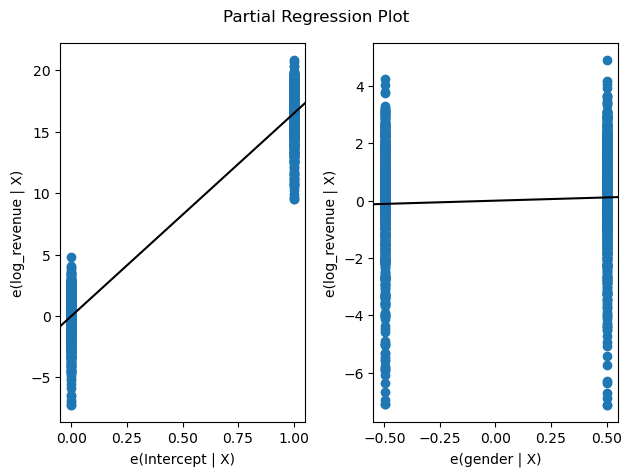

In [52]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

In [53]:
mod = smf.ols(formula='log_revenue ~ gender', data=df_matched.loc[7])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04714
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.828
Time:                        14:19:44   Log-Likelihood:                -1970.4
No. Observations:                 897   AIC:                             3945.
Df Residuals:                     895   BIC:                             3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.8324      0.105    160.562      0.0

## Log_revenue as a function of gender

In [54]:
df_matched.loc[[0,1,2,3,4,5]]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TSscore,...,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,Decade,gender,log_revenue
Decade,,,,,,,,,,,,,,,,,,,,,
0,378439,/m/0218yx,Arrowsmith,1931-12-07,NaN,108.0,"{""/m/06mp7"": ""Swedish Language"", ""/m/02bjrlw"":...",['United States of America'],"['Melodrama', 'Drama', 'Medical fiction', 'Bla...",89.0,...,2.0,Gottlieb,Leora,Tilda Swinton,Tilda Swinton,F,1931,0,0,NaN
0,22892307,/m/07scdbc,Elektra Luxx,2010-03-14,NaN,104.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action', 'Comedy', 'Indie']",24.0,...,0.0,Virgin,Mary,Julianne Moore,Julianne Moore,F,2010,0,0,NaN
0,34086866,/m/0hr6d1j,Pitch Perfect,2012-10-04,46226459.0,NaN,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Music', 'Musical', 'Comedy']",81.0,...,9.0,Aubrey,Jesse,Anna Camp,Anna Camp,F,2012,0,0,17.649063
0,61168,/m/0gln8,Flirtation Walk,1934,NaN,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romance Film', 'Musical', 'Black-and-white']",100.0,...,6.0,Dick,Biddle,Gabrielle Anwar,Gabrielle Anwar,F,1934,0,0,NaN
0,21762864,/m/05mqx7d,The Debt,2010-09-04,45636368.0,113.0,"{""/m/0cjk9"": ""Ukrainian Language"", ""/m/02h40lc...","['United States of America', 'United Kingdom']","['Thriller', 'Drama']",77.0,...,5.0,Rachel,David,Helen Mirren,Helen Mirren,F,2010,0,0,17.636216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1347325,/m/04vmhy,Puppet Master,1989-10-12,NaN,75.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Sup...",43.0,...,4.0,Neil,Megan,Jimmie F. Skaggs,Jimmie F. Skaggs,M,1989,5,1,NaN
5,17315314,/m/043n1r5,Yentl,1983-11-18,40218899.0,132.0,"{""/m/02h40lc"": ""English Language""}","['United States of America', 'United Kingdom']","['Musical', 'Feminist Film', 'Drama', 'Romance...",65.0,...,2.0,Avigdor,Hadass,Mandy Patinkin,Mandy Patinkin,M,1983,5,1,17.509848
5,1841530,/m/0604zn,Bachelor Party,1984-06-29,38400000.0,105.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/02h40lc""...",['United States of America'],"['Romance Film', 'Sex comedy', 'Comedy']",54.0,...,0.0,Rick,Debbie,Tom Hanks,Tom Hanks,M,1984,5,1,17.463568


In [55]:
mod = smf.ols(formula='log_revenue ~ gender+year', data=df_matched.loc[[0,1,2,3,4,5,6]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     50.17
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           7.96e-22
Time:                        14:19:44   Log-Likelihood:                -3071.9
No. Observations:                1518   AIC:                             6150.
Df Residuals:                    1515   BIC:                             6166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.0293      5.233     -6.694      0.0

In [56]:
mod = smf.ols(formula='log_revenue ~ gender+year', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5113
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.600
Time:                        14:19:44   Log-Likelihood:                -3263.9
No. Observations:                1515   AIC:                             6534.
Df Residuals:                    1512   BIC:                             6550.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6729     19.209      0.295      0.7

## TSscore as a function of gender

In [57]:
mod = smf.ols(formula='TSscore ~ gender+year', data=df_matched.loc[[0,1,2,3,4,5,6]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     304.7
Date:                Sat, 17 Dec 2022   Prob (F-statistic):          2.60e-118
Time:                        14:19:44   Log-Likelihood:                -10887.
No. Observations:                2336   AIC:                         2.178e+04
Df Residuals:                    2333   BIC:                         2.180e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1262.2158     48.750     25.891      0.0

In [58]:
mod = smf.ols(formula='TSscore ~ gender+year', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.105
Date:                Sat, 17 Dec 2022   Prob (F-statistic):            0.00615
Time:                        14:19:44   Log-Likelihood:                -9366.6
No. Observations:                1998   AIC:                         1.874e+04
Df Residuals:                    1995   BIC:                         1.876e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    627.3043    212.716      2.949      0.0

## RTaverage as a function of gender

In [59]:
mod = smf.ols(formula='RTaverage ~ gender+year', data=df_matched.loc[[4,5]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     22.60
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           3.29e-10
Time:                        14:19:44   Log-Likelihood:                -1138.5
No. Observations:                 640   AIC:                             2283.
Df Residuals:                     637   BIC:                             2296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    141.4237     20.178      7.009      0.0

In [60]:
mod = smf.ols(formula='RTaverage ~ gender+year', data=df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.876
Date:                Sat, 17 Dec 2022   Prob (F-statistic):            0.00772
Time:                        14:19:44   Log-Likelihood:                -3361.8
No. Observations:                1998   AIC:                             6730.
Df Residuals:                    1995   BIC:                             6746.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.7534     10.533      3.015      0.0

## Men/Women count in characters dataset

In [61]:
[list(df_character_usa.Actor_name.value_counts().index)]

[['Mel Blanc',
  'Oliver Hardy',
  'Moe Howard',
  'Larry Fine',
  'Harold Lloyd',
  'John Wayne',
  'Frank Welker',
  'Stan Laurel',
  'Roscoe Arbuckle',
  'Harry Carey',
  'Lon Chaney, Sr.',
  'Curly Howard',
  'Mickey Rooney',
  'William Garwood',
  'Samuel L. Jackson',
  'Leslie Nielsen',
  'John Carradine',
  'Hoot Gibson',
  'Bette Davis',
  'Jim Cummings',
  'Samuel Howard',
  'Mae Questel',
  'Christopher Walken',
  'Harry von Meter',
  'Glenn Ford',
  'Roy Rogers',
  'Charlie Chaplin',
  'Gary Cooper',
  'Buster Keaton',
  'Robert Duvall',
  'Boris Karloff',
  'Anthony Quinn',
  'Charlotte Burton',
  'Wallace Beery',
  'Dennis Hopper',
  'Lionel Barrymore',
  'John Goodman',
  'Huntz Hall',
  'Joan Crawford',
  'Robert Mitchum',
  'Burt Reynolds',
  'Vernon Dent',
  'Robert De Niro',
  'Rip Torn',
  'Steve Buscemi',
  'James Stewart',
  'Claudette Colbert',
  'Henry Fonda',
  'James Earl Jones',
  'Charles Durning',
  'Bruce Willis',
  'Eric Roberts',
  'Keenan Wynn',
  'Susan

In [62]:
df_character_usa_M = df_character_usa[df_character_usa.Actor_gender == 'M']
df_character_usa_F = df_character_usa[df_character_usa.Actor_gender == 'F']

In [63]:
count = df_character_usa.Actor_gender.value_counts()
count

M    152713
F     73456
Name: Actor_gender, dtype: int64

In [64]:
df_movie_usa

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_actor,Actor_name,Actor_gender,year,gender,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,1.0,0.0,Ballard,Williams,Natasha Henstridge,Natasha Henstridge,F,2001,0,7
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"[""Children's/Family"", 'Musical', 'Fantasy', 'C...",NaN,...,12.0,7.0,Mary,Banks,Julie Andrews,Julie Andrews,F,1964,0,3
2,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",71%,...,11.0,4.0,Jody,Yvette,Tyrese Gibson,Tyrese Gibson,M,2001,1,7
4,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Crime Fiction', 'Action/Adventure', 'Action'...",0%,...,2.0,2.0,Crowe,NaN,Peggy Lipton,Peggy Lipton,F,1989,0,5
5,5708633,/m/0f0d1p,The Great New Wonderful,2006-06-23,172055.0,87.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Ensemble Film', 'Comedy-drama', 'In...",NaN,...,0.0,1.0,Judy,Greer,Peggy Lipton,Peggy Lipton,F,2006,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Action/Adventure', 'Disaster']",61%,...,2.0,0.0,Jo,Bill,Cary Elwes,Cary Elwes,M,1996,1,6
12431,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","['France', 'United States of America']","['Thriller', 'Science Fiction', 'Action/Advent...",92%,...,11.0,4.0,Stevens,Goodwin,Jake Gyllenhaal,Jake Gyllenhaal,M,2011,1,0
12435,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Comedy of manners', 'Dram...",72%,...,10.0,0.0,Akeem,Lisa,Eddie Murphy,Eddie Murphy,M,1988,1,5
12437,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,1.0,Carla,Walt,Julia Stiles,Julia Stiles,F,2000,0,7


In [65]:
df_movie_usa['Male_count'] = df_movie_usa['gender']

In [66]:
df_movie_usa['Male_count'] = df_movie_usa['Male_count'].replace({0:1, 1:0})

In [67]:
df_movie_usa = df_movie_usa.rename(columns={'gender':'male_count','Male_count':'female_count'})

In [68]:
df_movie_usa['count'] = 1

In [69]:
group = df_movie_usa.groupby('Decade').sum()
group

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_46846/3790238580.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Wikipedia_movie_ID,Movie_revenue,Movie_runtime,feminine,sexist,sexiest,beauty,beautiful,positive_emotion,negative_emotion,Number_of_words,he_count,she_count,year,male_count,female_count,count
Decade,,,,,,,,,,,,,,,,,
0,12282662437,5.597256e+10,53960.5,730.0,0.0,0.0,174.0,0.0,1768.0,3122.0,372934.0,3563.0,2275.0,1063827,351,181,532
1,386286855,6.408725e+08,6711.0,55.0,0.0,0.0,24.0,0.0,180.0,242.0,29040.0,322.0,157.0,126381,49,16,65
2,3369588926,1.954511e+09,39263.0,436.0,0.0,0.0,115.0,0.0,856.0,1320.0,167739.0,1738.0,878.0,744424,275,106,381
3,574517570,3.803542e+09,14864.0,161.0,0.0,0.0,49.0,0.0,314.0,551.0,75896.0,645.0,399.0,233874,82,37,119
4,799569988,1.115284e+10,24502.0,277.0,0.0,0.0,63.0,0.0,478.0,1068.0,133613.0,1077.0,463.0,428638,159,58,217
5,3379091135,2.788360e+10,78608.0,793.0,0.0,0.0,243.0,0.0,1803.0,3276.0,417948.0,3510.0,1758.0,1491082,555,196,751
6,4371677234,8.148924e+10,133837.0,1412.0,0.0,0.0,407.0,0.0,3461.0,6358.0,775793.0,7651.0,3335.0,2463761,894,341,1235
7,10549116886,1.585124e+11,184084.0,2370.0,0.0,0.0,676.0,0.0,5555.0,9841.0,1220070.0,11628.0,6307.0,3472415,1240,492,1732


<AxesSubplot:xlabel='Decade', ylabel='count'>

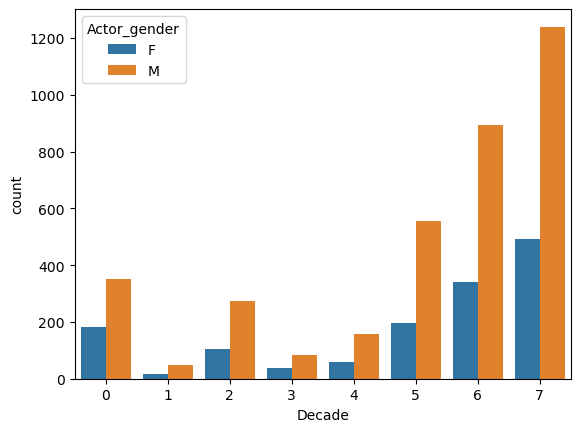

In [70]:
sns.barplot(x=df_movie_usa.Decade, y=df_movie_usa['count'], hue=df_movie_usa.Actor_gender, estimator=sum)

<AxesSubplot:>

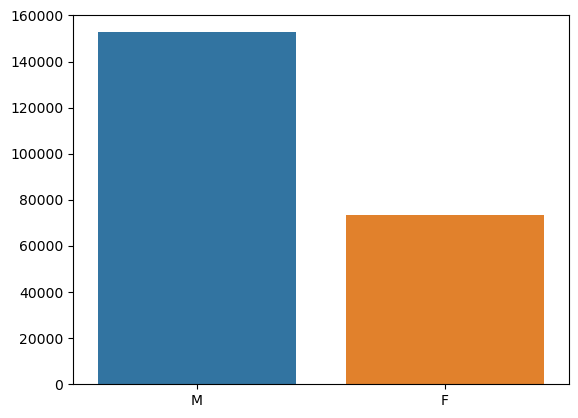

In [71]:
sns.barplot(x=count.index, y=count.values)

In [72]:
df_movie = pd.read_table(data_folder +'movie.metadata.tsv',header=None)
df_movie.columns=['Wikipedia_movie_ID' , 'Freebase_movie_ID', 'Movie_name' , 'Movie_date' , 'Movie_revenue' , 'Movie_runtime' , 'Movie_languages' , 'Movie_countries' , 'Movie_genres']
genres = df_movie['Movie_genres']
genres =  genres.apply(lambda x: x.replace('{','').replace('}','')) 

In [73]:
genres = genres.str.split(',')

In [74]:
genres_list = genres.explode().value_counts()
genres_list

 "/m/07s9rl0": "Drama"             22491
 "/m/01z4y": "Comedy"              13586
"/m/07s9rl0": "Drama"              11516
 "/m/01g6gs": "Black-and-white"     8162
"/m/02hmvc": "Short Film"           7598
                                   ...  
"/m/05bdtfl": "Period Horror"          1
"/m/0hj3mx7": "Business"               1
"/m/094ddt": "Doomsday film"           1
 "/m/0c031k6": "Live action"           1
 "/m/05453r": "Homoeroticism"          1
Name: Movie_genres, Length: 654, dtype: int64

In [75]:
query = '''
SELECT ?movie ?genreLabel ?freebase_id
WHERE
{ SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  ?movie wdt:P31 wd:Q11424.  # ?movie is an instance of Q11424 (film)
  ?movie wdt:P495 wd:Q30.  # ?movie is produced in the US
  ?movie wdt:P136 ?genre.  # ?movie has a genre of ?genre
  ?movie wdt:P646 ?freebase_id.  # ?movie has a Freebase ID of ?freebase_id
}
'''

In [76]:
genrewiki = wikidata2df(query)
genrewiki = genrewiki.drop_duplicates('freebase_id')

In [77]:
df_movie_usa = pd.read_csv('df_movie_usa.csv')

In [78]:
genrewiki.genreLabel.value_counts()

drama film             12280
comedy film             4335
documentary film        3096
horror film             2154
Western film            1994
                       ...  
heavy metal                1
film based on books        1
biography                  1
cannibal film              1
humour                     1
Name: genreLabel, Length: 206, dtype: int64

In [79]:
new = df_movie_usa.merge(genrewiki, left_on='Freebase_movie_ID', right_on='freebase_id',how='left')

In [80]:
new

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,Number_of_words,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,genreLabel,movie,freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,396.0,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,action film,Q261700,/m/03vyhn
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drama film,Q1619977,/m/02qc0j7
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,drama film,Q1579725,/m/017n1p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,252.0,1.0,1.0,Carla,Walt,F,Julia Stiles,drama film,Q960668,/m/0660qx
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,611.0,6.0,8.0,Greenhill,Haines,M,Don Johnson,erotic film,Q387868,/m/030xw6
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,comedy film,Q7769294,/m/07k5mlk
34406,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],['Drama'],NaN,...,118.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
new = new.dropna(subset=['genreLabel'])

In [82]:
decades = ['1930-1940','1940-1950','1950-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010']
decades_code = range(len(decades))
new['Decade'] = 0
for ctr,decade in enumerate(decades):
    index1 = new[ (new['Movie_date']>decade[0:3]) & (new['Movie_date']<decade[5:8])].index
    new.loc[index1,'Decade'] = decades_code[ctr]

/var/folders/yv/q6fl_nv53dv6l2kfbv_6jc680000gn/T/ipykernel_46846/3624480765.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
new

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_date,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,TS score_x,...,he_count,she_count,Principal_summary_character,Secondary_summary_character,Principal_character_sex,Principal_character_actor,genreLabel,movie,freebase_id,Decade
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",22%,...,1.0,0.0,Ballard,Williams,F,Natasha Henstridge,action film,Q261700,/m/03vyhn,7
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",80%,...,NaN,NaN,NaN,NaN,NaN,NaN,drama film,Q1619977,/m/02qc0j7,0
4,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,drama film,Q1579725,/m/017n1p,0
5,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,...,2.0,5.0,Adam,Kate,NaN,NaN,romantic comedy,Q6649585,/m/0gffwj,6
9,175024,/m/017n1b,The Devil's Holiday,1930,NaN,NaN,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Romance Film', 'Drama', 'Black-and-white']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,drama film,Q729807,/m/017n1b,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34402,26044505,/m/0b6m67n,The Flying Serpent,1946,NaN,59.0,{},['United States of America'],"['Thriller', 'B-movie', 'Horror']",NaN,...,1.0,0.0,Andrew,Forbes,NaN,NaN,horror film,Q7734623,/m/0b6m67n,1
34403,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","['France', 'United States of America']","['Parody', 'Americana', 'Comedy']",85%,...,1.0,1.0,Carla,Walt,F,Julia Stiles,drama film,Q960668,/m/0660qx,7
34404,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},['United States of America'],"['Thriller', 'Erotic thriller', 'Psychological...",38%,...,6.0,8.0,Greenhill,Haines,M,Don Johnson,erotic film,Q387868,/m/030xw6,6
34405,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,"{""/m/02h40lc"": ""English Language""}",['United States of America'],"['Comedy film', 'Romance Film', 'Musical']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,comedy film,Q7769294,/m/07k5mlk,1


In [84]:
new = new.groupby(['Decade','genreLabel'],group_keys=True).apply(lambda x:x)
new.index = new.index.droplevel(2)

In [85]:
new.genreLabel.value_counts()

drama film               8215
comedy film              2920
documentary film         1788
horror film              1475
action film              1229
                         ... 
children's literature       1
burlesque                   1
autobiography               1
essay film                  1
world music                 1
Name: genreLabel, Length: 167, dtype: int64

In [86]:
new = new[(new.genreLabel=='drama film') | (new.genreLabel=='comedy film') | (new.genreLabel=='documentary film') | (new.genreLabel=='horror film') | (new.genreLabel=='action film')]

In [87]:
new['count'] = 1

In [88]:
new = new.dropna(subset=['Principal_character_actor'])

<AxesSubplot:xlabel='Decade', ylabel='count'>

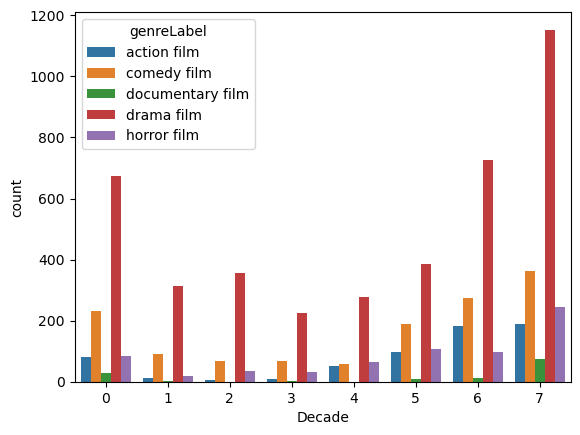

In [89]:
sns.barplot(x=new.Decade, y=new['count'], hue = new.genreLabel, estimator=sum)

## Drama film

In [90]:
drama = new[new.genreLabel=='drama film']

In [91]:
drama = drama.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = drama.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
drama = merge.drop(columns=['Principal_character_sex'])
drama = drama[(drama.Actor_gender == 'M') | (drama.Actor_gender == 'F')]

In [92]:
drama.Actor_gender.value_counts()

M    2811
F    1284
Name: Actor_gender, dtype: int64

In [93]:
drama['gender'] = drama['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [94]:
drama = drama.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [95]:
drama.index = drama.index.droplevel(1)

In [96]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(drama.index.value_counts().index):
    count = drama.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = drama.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(drama)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(drama)/2)))

The number of athletes discarded is : 1527
The number of matched pairs is : 2047


In [97]:
df_matched['TS score_x'] = df_matched['TS score_x'].str.replace("\%", "", regex=True)
df_matched['RT average_x'] = df_matched['RT average_x'].str.split('/').str[0].astype(float)
df_matched['TS score_x'] = df_matched['TS score_x'].astype(float)
df_matched.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [98]:
df_matched = df_matched.dropna(subset=['Movie_date'])

In [99]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [100]:
mod = smf.ols(formula = 'TSscore ~ gender', data = df_matched.loc[[0,1]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.035
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.155
Time:                        14:20:21   Log-Likelihood:                -1619.4
No. Observations:                 338   AIC:                             3243.
Df Residuals:                     336   BIC:                             3250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.8571      2.303     30.762      0.0

In [101]:
mod = smf.ols(formula = 'TSscore ~ gender+year', data = df_matched.loc[[5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                TSscore   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     25.12
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           2.03e-11
Time:                        14:20:21   Log-Likelihood:                -5709.8
No. Observations:                1231   AIC:                         1.143e+04
Df Residuals:                    1228   BIC:                         1.144e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1257.7475    182.062      6.908      0.0

In [102]:
mod = smf.ols(formula = 'RTaverage ~ gender+year', data = df_matched.loc[[0,1,2,3,4,5,6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     192.6
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           1.01e-76
Time:                        14:20:21   Log-Likelihood:                -3085.1
No. Observations:                1856   AIC:                             6176.
Df Residuals:                    1853   BIC:                             6193.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.4782      2.757     21.572      0.0

In [103]:
mod = smf.ols(formula = 'RTaverage ~ gender+year', data = df_matched.loc[[0,1,2,3,4,5]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     100.8
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           6.65e-40
Time:                        14:20:21   Log-Likelihood:                -1408.5
No. Observations:                 830   AIC:                             2823.
Df Residuals:                     827   BIC:                             2837.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.8951      3.648     15.872      0.0

In [104]:
mod = smf.ols(formula = 'RTaverage ~ gender+year', data = df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.260
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           0.000276
Time:                        14:20:21   Log-Likelihood:                -1674.0
No. Observations:                1026   AIC:                             3354.
Df Residuals:                    1023   BIC:                             3369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.6845     14.187      3.643      0.0

## Comedy film

In [105]:
comedy = new[new.genreLabel=='comedy film']

In [106]:
comedy = comedy.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = comedy.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
comedy = merge.drop(columns=['Principal_character_sex'])
comedy = comedy[(comedy.Actor_gender == 'M') | (comedy.Actor_gender == 'F')]

In [107]:
comedy.Actor_gender.value_counts()

M    1007
F     333
Name: Actor_gender, dtype: int64

In [108]:
comedy['gender'] = comedy['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [109]:
comedy = comedy.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [110]:
comedy.index = comedy.index.droplevel(1)

In [111]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(comedy.index.value_counts().index):
    count = comedy.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = comedy.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(comedy)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(comedy)/2)))

The number of athletes discarded is : 674
The number of matched pairs is : 670


In [112]:
df_matched['TS score_x'] = df_matched['TS score_x'].str.replace("\%", "", regex=True)
df_matched['RT average_x'] = df_matched['RT average_x'].str.split('/').str[0].astype(float)
df_matched['TS score_x'] = df_matched['TS score_x'].astype(float)
df_matched.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [113]:
df_matched = df_matched.dropna(subset=['Movie_date'])

In [116]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [129]:
mod = smf.ols(formula = 'RTaverage ~ gender+year', data = df_matched.loc[[0,1,2,3,4,5]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     18.00
Date:                Sat, 17 Dec 2022   Prob (F-statistic):           8.02e-08
Time:                        14:34:30   Log-Likelihood:                -288.06
No. Observations:                 174   AIC:                             582.1
Df Residuals:                     171   BIC:                             591.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.5351      8.800      6.652      0.0

In [121]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched.loc[[6,7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.010
Date:                Sat, 17 Dec 2022   Prob (F-statistic):             0.0263
Time:                        14:33:43   Log-Likelihood:                -334.43
No. Observations:                 201   AIC:                             672.9
Df Residuals:                     199   BIC:                             679.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1602      0.133     38.761      0.0

## Action film

In [130]:
action = new[new.genreLabel=='action film']

In [131]:
action = action.dropna(subset=['Principal_character_actor'])
dfactor_gender = df_character_usa[['Actor_name','Actor_gender']]
dfactor_gender = dfactor_gender.drop_duplicates()
merge = action.merge(dfactor_gender, left_on='Principal_character_actor', right_on='Actor_name', how='left')
action = merge.drop(columns=['Principal_character_sex'])
action = action[(action.Actor_gender == 'M') | (action.Actor_gender == 'F')]

In [132]:
action.Actor_gender.value_counts()

M    492
F    133
Name: Actor_gender, dtype: int64

In [133]:
action['gender'] = action['Actor_gender'].apply(lambda x: 1 if x =='M' else 0)

In [135]:
action = action.groupby(['Decade'],group_keys=True).apply(lambda x:x)

In [136]:
action.index = action.index.droplevel(1)

In [138]:
df_matched = pd.DataFrame()
# For loop on the unique index in df4
for i in list(action.index.value_counts().index):
    count = action.loc[i]['gender'].value_counts()               # Count the number of 0 and 1
    l = len(count)                                              # Count number of elements (1 if only 0 or 1)
    df_temp = action.loc[i]                                        # temporary DF containing elements that has the same index
    min = count.min()                                           # report the minimum value between number of 0 and number of 1
    if l != 2:                                                  #continue if only 0 or only 1
        continue
    df1 = df_temp[df_temp.gender == 0].sample(min)            # select randomly a number of values corresponding to the minimum occurence of 0 or 1
    df2 = df_temp[df_temp.gender == 1].sample(min)
    df_matched = pd.concat([df1,df2,df_matched])                # join the results in df_matched
    

print('The number of athletes discarded is : '+ str(len(action)-len(df_matched)))
print('The number of matched pairs is : '+ str(int(len(action)/2)))

The number of athletes discarded is : 359
The number of matched pairs is : 312


In [139]:
df_matched['TS score_x'] = df_matched['TS score_x'].str.replace("\%", "", regex=True)
df_matched['RT average_x'] = df_matched['RT average_x'].str.split('/').str[0].astype(float)
df_matched['TS score_x'] = df_matched['TS score_x'].astype(float)
df_matched.rename(columns = {'TS score_x':'TSscore', 'RT average_x':'RTaverage'}, inplace = True)

In [140]:
df_matched = df_matched.dropna(subset=['Movie_date'])

In [141]:
df_matched['year'] = df_matched['Movie_date'].apply(lambda x: int(x[0:4]))

In [149]:
mod = smf.ols(formula = 'RTaverage ~ gender', data = df_matched.loc[[7]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              RTaverage   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6876
Date:                Sat, 17 Dec 2022   Prob (F-statistic):              0.411
Time:                        14:40:00   Log-Likelihood:                -91.797
No. Observations:                  55   AIC:                             187.6
Df Residuals:                      53   BIC:                             191.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7074      0.252     18.698      0.0